# Transfer Learning with MobileNetV2
Transfer Learning in Neural Network is a technique used in machine learning where knowledge gained from training one model (source domain) is transferred and applied to a **different but related** model (target domain). In neural networs, this involves taking a pre-trained model developed for one task and fine-tuned or using its learned features to solve another related task.

In this project I will be implementing a model using transfer learning with [**MobileNetV2**](https://arxiv.org/pdf/1801.04381.pdf) as the source model. The model will predict an image is an Alpaca image or not Alpaca image.

New things learned:
1. Creat dataset from a directory
2. Preprocess and augment data using the Sequential API
3. Adapt a pretrained model to new data and train a classifier using the functional API MobileNet
4. Fine-tune a classifier's final layer to improve accuracy

<div><div class="alert alert-info">
    <h3>Table of content:</h3>
    <ol>
        <li><a href="#create_dataset">Create Dataset and split into Train and Validation sets</a></li>
        <li><a href="#preprocess_train_set">Preprocess and Augment Train set</a></li>
        <li><a href="#resnet50_function">Implement ResNet (50 Layers)</a></li>
        <li><a href="#configure_learning_process">Configure Learning Process</a></li>
        <li><a href="#using_mobilenet">Using MobileNet50V2 and Transfer Learning</a></li>
        <li><a href="#prepare_base_model">Prepare the model (no fine-tune)</a></li>
        <li><a href="#compile_and_fit">Compile and fit the model (no fine-tune)</a></li>
        <li><a href="#accuracy_no_fine_tune">Training and Validatin accuracy (no fine-tune)</a></li>
        <li><a href="#fine_tune_model">Fine-tune the model</a></li>
        <li><a href="#accuracy_after_fine_tune">Training and Validatin accuracy (after fine-tune)</a></li>
        <li><a href="#save_model">Save the model</a></li>
    </ol>
</div>

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import ModelCheckpoint

<a id="create_dataset"></a>
## Create Dataset and split into Train and Validation sets
***Keras*** provides `image_data_set_from_directory()` method for generating image dataset from images stored in the disk. We can specify `validation_split=0.2` (or any other value) as the size of the validation set, and create training set using `subset='training'` and validatin set using `subset='validation'`.

In [24]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


### Let's display some images in the train set

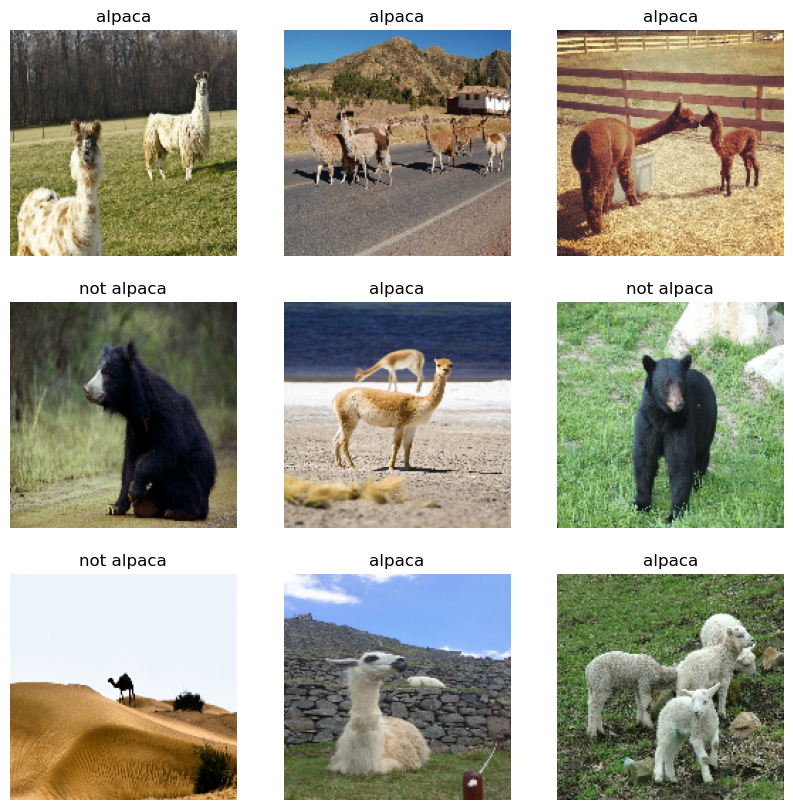

In [25]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

<a id="preprocess_train_set"></a>
## Preprocess and Augment Training Data
Data augmentation is one of the ways to increase our train set size and the diversity by applying random (but realistic) transformation, such as image rotation. ***Keras*** provides various methods to perform data augmentation effectively.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Implementation of data augmenter

In [27]:
def data_augmenter():
    """
    Create Sequential model composed of 2 layers
    Returns:
    tf.keras.Sequential
    """
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Now we can use above function to populate our training set

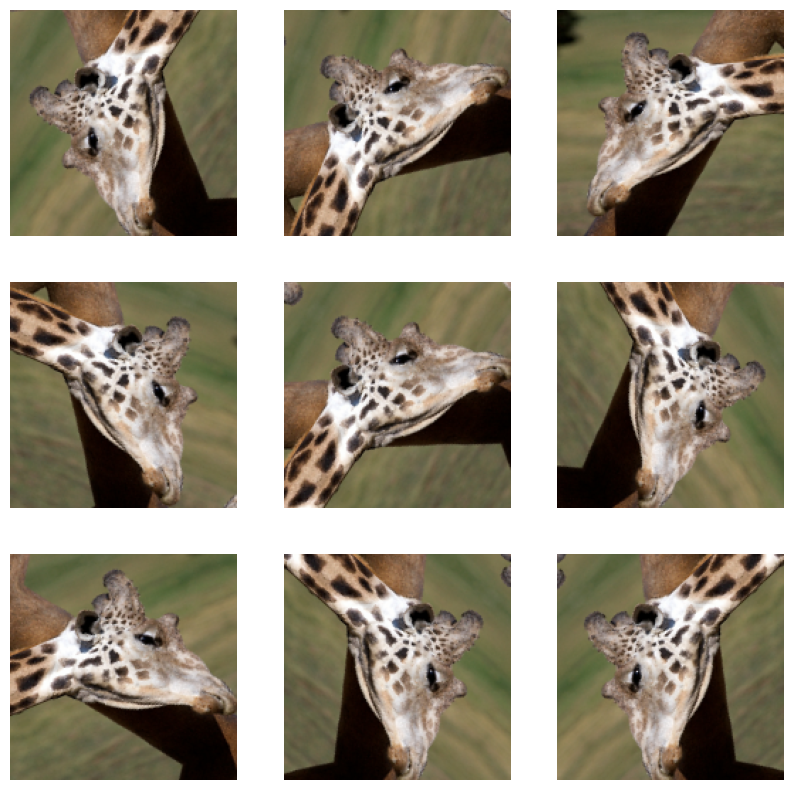

In [28]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a id="using_mobilenet"></a>
## Using MobileNetV2 for Transfer Learning
MobileNetV2 was trained on [ImageNet](https://www.image-net.org/) and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentatoin tasks, as well as classification tasks. The architecture has tree defining characteristics.
1. Depthwise separable convolutions
2. Thin input bottlenecks between layers
3. Shortcut connection between bottleneck layers

<center><img src="images/mobilenetv2.png" width="750" /></center>

Each block consists of an **verted residual** structure with a **bottleneck** at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space. and prevent no-linearities from destroying important information.

The **shortcut connections**, which are similar to the ones in traditinal residual network, serves the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

In [30]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                              weights='imagenet')

In [31]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

The last 2 layers (top layers) are responsible for the classification in the model.

In [32]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_2
predictions


In Tranfer learning, we have to implement our own Top layers to predict what we want according to our problem statement. Let's build alpheca_model.

<a id="prepare_base_model"></a>
## Prepare the model

In [33]:
def alpaca_model(image_shape=IMG_SIZE, data_aumentation=data_augmenter()):
    """
    Define a tr.keras model for binary classification out of the MobileNetV2 model
    
    Arguments:
        image_shape -- Image Width and Height
        data_aumentation -- data augmentation function
    
    Returns:
    tf.keras.Model
    """
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetV2 input size)
    inputs = tf.keras.Input(shape=input_shape)
    
    # apply data augmentation
    x = data_aumentation(inputs)
    
    # data preprocessing using the same weights and the model was trained
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add new binary classification layers
    x = tfl.GlobalAveragePooling2D()(x)
    
    # add dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
    
    # use a prediction layer with one neuron as a binary classifier only needs one
    outputs = tfl.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Now we can create the new model using data_aumentation function defined earlier.

In [34]:
model_alpaca = alpaca_model(IMG_SIZE, data_augmentation)

<a id="compile_and_fit"></a>
## Compile the model

In [35]:
base_learning_rate = 0.001
cp = ModelCheckpoint('models/', monitor='accuracy', save_best_only=True)
model_alpaca.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [36]:
initial_epochs = 5
history = model_alpaca.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, verbose=2, callbacks=[cp])

Epoch 1/5


C:\Users\navilog\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 20s - loss: 0.7491 - accuracy: 0.6221 - val_loss: 0.6515 - val_accuracy: 0.6462 - 20s/epoch - 2s/step
Epoch 2/5
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 17s - loss: 0.6713 - accuracy: 0.6489 - val_loss: 0.4944 - val_accuracy: 0.7385 - 17s/epoch - 2s/step
Epoch 3/5
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 16s - loss: 0.5419 - accuracy: 0.7328 - val_loss: 0.4579 - val_accuracy: 0.7538 - 16s/epoch - 2s/step
Epoch 4/5
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 16s - loss: 0.4302 - accuracy: 0.7824 - val_loss: 0.3946 - val_accuracy: 0.8000 - 16s/epoch - 2s/step
Epoch 5/5
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 17s - loss: 0.4229 - accuracy: 0.8053 - val_loss: 0.3735 - val_accuracy: 0.8000 - 17s/epoch - 2s/step


<a id="accuracy_no_fine_tune"></a>
## Training and Validation accuracy

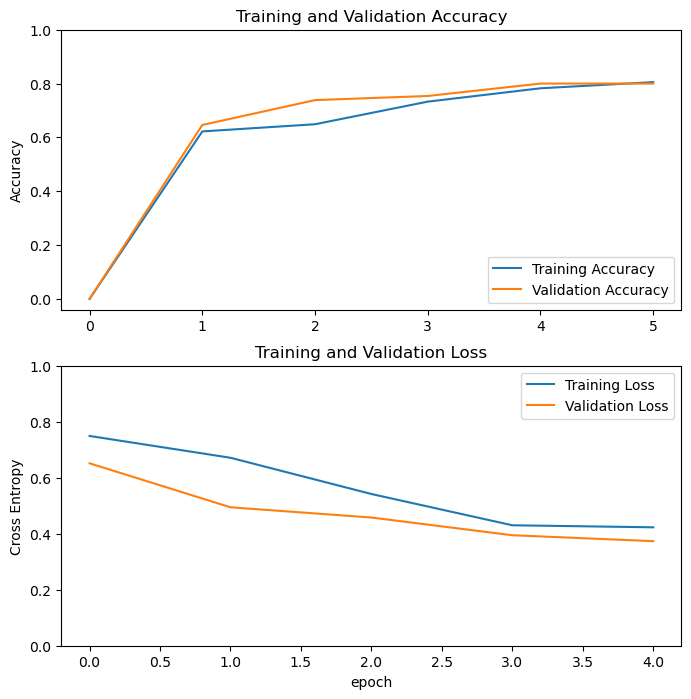

In [37]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
class_names

['alpaca', 'not alpaca']

Everything is working fine. But the accuracy of the model is not so good. We need to fine-tune the model to get a better accuracy.

<a id="fine_tune_model"></a>
## Fine-tune the model
Currently I have freezed all the layers from learning. That means the model_alpaca entirely relies on weights from ImageNet data. But at some points we need to give some information to the model from our images as well. So, where we can do that?
- At the earlier stages of the network, model learns about basic and low-level features like edges. This is common for any image processing task.
- But at the end of the entwork model learns very high-level information like pointy ears and hairy tails. That is where we need to pay attention.

I have followed these steps for fine-tune process.
1. un-freez all the layers of model_alpaca
2. select number of layers at the end of the network for enable training
3. set a low learning rate for these layers
4. retrain the model

In [39]:
base_model_f = model_alpaca.layers[4]
base_model_f.trainable = True

# We have 155 layers in the MobileNetV2
print("# Layers in the base model: ", len(base_model_f.layers))

# fine-tune from this layer onwards
fine_tune_from = 120

# freez all the layers before the 'fine_tune_from' layer
for layer in base_model_f.layers[:fine_tune_from]:
    layer.trainable = True
    
# Define a BinaryCrossEntropy loss function.
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define Adam optimizer with learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)

# use 'accuracy' as the evaluation matric
metrics = ['accuracy']

model_alpaca.compile(loss=loss_function,
                     optimizer=optimizer,
                     metrics=metrics)

# Layers in the base model:  154


In [40]:
model_alpaca.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [41]:
fine_tune_epochs = 150
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model_alpaca.fit(train_dataset,
                                     epochs=total_epochs,
                                     initial_epoch=history.epoch[-1],
                                     validation_data=validation_dataset,
                                     verbose=2,
                                     callbacks=[cp])

Epoch 5/155


C:\Users\navilog\anaconda3\lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 - 19s - loss: 0.5037 - accuracy: 0.7405 - val_loss: 0.2147 - val_accuracy: 0.9077 - 19s/epoch - 2s/step
Epoch 6/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 23s - loss: 0.4404 - accuracy: 0.8130 - val_loss: 0.2505 - val_accuracy: 0.9077 - 23s/epoch - 3s/step
Epoch 7/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 23s - loss: 0.3666 - accuracy: 0.8206 - val_loss: 0.3033 - val_accuracy: 0.8308 - 23s/epoch - 3s/step
Epoch 8/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 24s - loss: 0.2687 - accuracy: 0.8817 - val_loss: 0.1777 - val_accuracy: 0.9231 - 24s/epoch - 3s/step
Epoch 9/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 24s - loss: 0.2015 - accuracy: 0.9389 - val_loss: 0.1356 - val_accuracy: 0.9538 - 24s/epoch - 3s/step
Epoch 10/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 24s - loss: 0.1314 - accuracy: 0.9504 - val_loss: 0.0862 - val_accuracy: 0.9692 - 24s/epoch - 3s/step
Epoch 11/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 25s - loss: 0.1316 - accuracy: 0.9580 - val_loss: 0.1575 - val_accuracy: 0.9538 - 25s/epoch - 3s/step
Epoch 12/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 25s - loss: 0.1009 - accuracy: 0.9656 - val_loss: 0.0975 - val_accuracy: 0.9538 - 25s/epoch - 3s/step
Epoch 13/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 26s - loss: 0.0679 - accuracy: 0.9771 - val_loss: 0.0588 - val_accuracy: 0.9692 - 26s/epoch - 3s/step
Epoch 14/155
INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


9/9 - 24s - loss: 0.0491 - accuracy: 0.9962 - val_loss: 0.1267 - val_accuracy: 0.9231 - 24s/epoch - 3s/step
Epoch 15/155
9/9 - 9s - loss: 0.0744 - accuracy: 0.9695 - val_loss: 0.8838 - val_accuracy: 0.7846 - 9s/epoch - 995ms/step
Epoch 16/155
9/9 - 9s - loss: 0.1243 - accuracy: 0.9389 - val_loss: 0.1219 - val_accuracy: 0.9692 - 9s/epoch - 977ms/step
Epoch 17/155
9/9 - 10s - loss: 0.0829 - accuracy: 0.9809 - val_loss: 0.8060 - val_accuracy: 0.7538 - 10s/epoch - 1s/step
Epoch 18/155
9/9 - 9s - loss: 0.1926 - accuracy: 0.9160 - val_loss: 0.1224 - val_accuracy: 0.9692 - 9s/epoch - 987ms/step
Epoch 19/155
9/9 - 10s - loss: 0.0677 - accuracy: 0.9809 - val_loss: 0.0766 - val_accuracy: 0.9692 - 10s/epoch - 1s/step
Epoch 20/155
9/9 - 9s - loss: 0.0484 - accuracy: 0.9924 - val_loss: 0.0696 - val_accuracy: 0.9692 - 9s/epoch - 971ms/step
Epoch 21/155
9/9 - 10s - loss: 0.0588 - accuracy: 0.9809 - val_loss: 0.2409 - val_accuracy: 0.8923 - 10s/epoch - 1s/step
Epoch 22/155
9/9 - 9s - loss: 0.0643 - ac

INFO:tensorflow:Assets written to: models\assets


9/9 - 23s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.9846 - 23s/epoch - 3s/step
Epoch 28/155
9/9 - 8s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9846 - 8s/epoch - 901ms/step
Epoch 29/155
9/9 - 10s - loss: 0.0105 - accuracy: 0.9962 - val_loss: 0.1002 - val_accuracy: 0.9692 - 10s/epoch - 1s/step
Epoch 30/155
9/9 - 9s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1050 - val_accuracy: 0.9692 - 9s/epoch - 1s/step
Epoch 31/155
9/9 - 10s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9692 - 10s/epoch - 1s/step
Epoch 32/155
9/9 - 8s - loss: 0.0060 - accuracy: 0.9962 - val_loss: 0.1884 - val_accuracy: 0.9231 - 8s/epoch - 929ms/step
Epoch 33/155
9/9 - 9s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 0.9692 - 9s/epoch - 1s/step
Epoch 34/155
9/9 - 9s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 0.9846 - 9s/epoch - 1s/step
Epoch 35/155
9/9 - 10s - loss: 0.0067 - accuracy:

Above logs show that clear improvment of the model, even though we did a very small fine-tune to the model.

<a id="accuracy_after_fine_tune"></a>
## Accuracy after fine-tuning the model

In [42]:
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

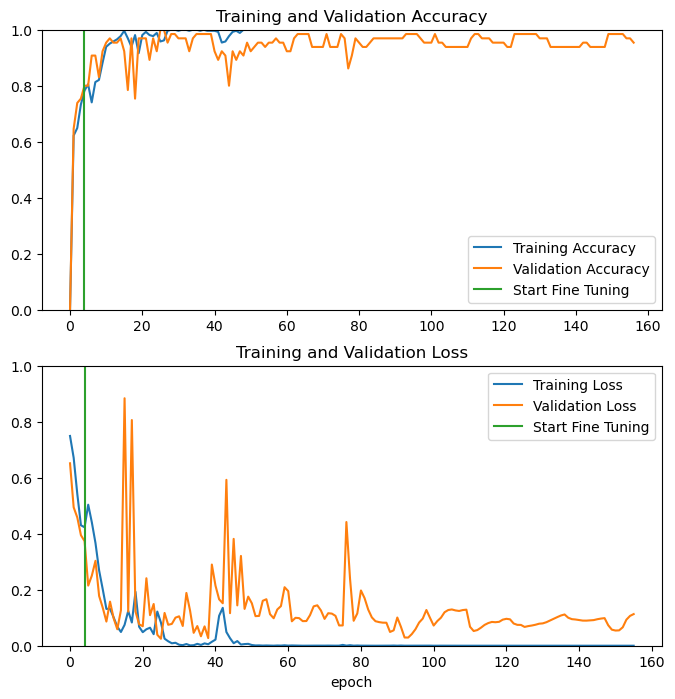

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<a id="save_model"></a>
## Save the model

In [44]:
#model_alpaca.save('models/alpaca_mobile_netv2.keras')